In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error 
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

<h1 style="color: #FF8C00;">01 | Data Extraction </h1>

In [2]:
data_demand = pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/Data/ng-demand-14da-hh.csv")
df_demand = data_demand.copy()


In [3]:
df_demand.head(3)

,DATE,CTIME,GDATETIME,NATIONALDEMAND
0,2025-04-19,30,2025-04-18T23:30:00,18847
1,2025-04-19,100,2025-04-19T00:00:00,18358
2,2025-04-19,130,2025-04-19T00:30:00,18207


In [4]:
df_demand.shape

(624, 4)

In [5]:
df_demand.columns = [column.lower().replace(' ', '_') for column in df_demand.columns]

In [6]:
duplicate_rows = df_demand.duplicated().sum()
duplicate_rows


np.int64(0)

In [7]:
nan_values = df_demand.isna().sum()
nan_values


date              0
ctime             0
gdatetime         0
nationaldemand    0
dtype: int64

In [8]:
empty_spaces = df_demand.eq(' ').sum()
empty_spaces

date              0
ctime             0
gdatetime         0
nationaldemand    0
dtype: int64

In [9]:
df_demand.dtypes

date              object
ctime              int64
gdatetime         object
nationaldemand     int64
dtype: object

<h1 style="color: #FF8C00;">02 | Data Cleaning </h1>

<h2 style="color: #FF6347;">Dropping unnecessary columns</h2>

In [10]:
df_demand['gdatetime'] = pd.to_datetime(df_demand['gdatetime'])

df_demand = df_demand[df_demand['gdatetime'].dt.minute != 30] #only keep hourly values

df_demand = df_demand.reset_index(drop=True)

In [11]:
columns = df_demand.columns.tolist()
columns

['date', 'ctime', 'gdatetime', 'nationaldemand']

In [12]:
df_demand['gdatetime'] = pd.to_datetime(df_demand['gdatetime'])
df_demand['date'] = df_demand['gdatetime'].dt.date
df_demand['hour'] = df_demand['gdatetime'].dt.hour + 1
df_demand

,date,ctime,gdatetime,nationaldemand,hour
0,2025-04-19,100,2025-04-19 00:00:00,18358,1
1,2025-04-19,200,2025-04-19 01:00:00,18423,2
2,2025-04-19,300,2025-04-19 02:00:00,17705,3
3,2025-04-19,400,2025-04-19 03:00:00,17214,4
4,2025-04-19,500,2025-04-19 04:00:00,16922,5
...,...,...,...,...,...
307,2025-05-01,2000,2025-05-01 19:00:00,29863,20
308,2025-05-01,2100,2025-05-01 20:00:00,29666,21
309,2025-05-01,2200,2025-05-01 21:00:00,27897,22
310,2025-05-01,2300,2025-05-01 22:00:00,25072,23


In [15]:
df_demand = df_demand[['date', 'hour', 'nationaldemand']]

In [16]:
df_demand

,date,hour,nationaldemand
0,2025-04-19,1,18358
1,2025-04-19,2,18423
2,2025-04-19,3,17705
3,2025-04-19,4,17214
4,2025-04-19,5,16922
...,...,...,...
307,2025-05-01,20,29863
308,2025-05-01,21,29666
309,2025-05-01,22,27897
310,2025-05-01,23,25072


Embedded Wind and Solar

In [17]:
data_embedded = pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/Data/202504170912_embedded_forecast.csv")
df_embedded = data_embedded.copy()


In [18]:
df_embedded.head(3)

,DATE_GMT,TIME_GMT,SETTLEMENT_DATE,SETTLEMENT_PERIOD,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY
0,2025-04-17T00:00:00,08:30,2025-04-17T00:00:00,19,1203,6606,5464,18720
1,2025-04-17T00:00:00,09:00,2025-04-17T00:00:00,20,1133,6606,6376,18720
2,2025-04-17T00:00:00,09:30,2025-04-17T00:00:00,21,1090,6606,7347,18720


In [19]:
df_embedded.shape

(606, 8)

In [20]:
df_embedded.columns = [column.lower().replace(' ', '_') for column in df_embedded.columns]

In [21]:
duplicate_rows = df_embedded.duplicated().sum()
duplicate_rows


np.int64(0)

In [22]:
nan_values = df_embedded.isna().sum()
nan_values

date_gmt                   0
time_gmt                   0
settlement_date            0
settlement_period          0
embedded_wind_forecast     0
embedded_wind_capacity     0
embedded_solar_forecast    0
embedded_solar_capacity    0
dtype: int64

In [23]:
empty_spaces = df_embedded.eq(' ').sum()
empty_spaces

date_gmt                   0
time_gmt                   0
settlement_date            0
settlement_period          0
embedded_wind_forecast     0
embedded_wind_capacity     0
embedded_solar_forecast    0
embedded_solar_capacity    0
dtype: int64

In [24]:
df_embedded.dtypes

date_gmt                   object
time_gmt                   object
settlement_date            object
settlement_period           int64
embedded_wind_forecast      int64
embedded_wind_capacity      int64
embedded_solar_forecast     int64
embedded_solar_capacity     int64
dtype: object

In [25]:
# Filtern der Zeilen, um nur volle Stunden zu behalten
df_embedded = df_embedded[~df_embedded['time_gmt'].str.endswith(':30')]

# Index neu setzen
df_embedded.reset_index(drop=True, inplace=True)
df_embedded

,date_gmt,time_gmt,settlement_date,settlement_period,embedded_wind_forecast,embedded_wind_capacity,embedded_solar_forecast,embedded_solar_capacity
0,2025-04-17T00:00:00,09:00,2025-04-17T00:00:00,20,1133,6606,6376,18720
1,2025-04-17T00:00:00,10:00,2025-04-17T00:00:00,22,1047,6606,8248,18720
2,2025-04-17T00:00:00,11:00,2025-04-17T00:00:00,24,989,6606,9323,18720
3,2025-04-17T00:00:00,12:00,2025-04-17T00:00:00,26,1047,6606,9269,18720
4,2025-04-17T00:00:00,13:00,2025-04-17T00:00:00,28,1021,6606,8320,18720
...,...,...,...,...,...,...,...,...
298,2025-04-29T00:00:00,19:00,2025-04-29T00:00:00,40,1504,6606,1433,18799
299,2025-04-29T00:00:00,20:00,2025-04-29T00:00:00,42,1481,6606,220,18799
300,2025-04-29T00:00:00,21:00,2025-04-29T00:00:00,44,1468,6606,0,18799
301,2025-04-29T00:00:00,22:00,2025-04-29T00:00:00,46,1464,6606,0,18799


In [26]:
df_embedded['settlement_date'] = pd.to_datetime(df_embedded['settlement_date'])
df_embedded['time_gmt'] = pd.to_datetime(df_embedded['time_gmt'])
df_embedded['date'] = df_embedded['settlement_date'].dt.date
df_embedded['hour'] = df_embedded['time_gmt'].dt.hour + 1


In [27]:
df_embedded = df_embedded[['date', 'hour', 'embedded_wind_forecast', 'embedded_solar_forecast']]
df_embedded

,date,hour,embedded_wind_forecast,embedded_solar_forecast
0,2025-04-17,10,1133,6376
1,2025-04-17,11,1047,8248
2,2025-04-17,12,989,9323
3,2025-04-17,13,1047,9269
4,2025-04-17,14,1021,8320
...,...,...,...,...
298,2025-04-29,20,1504,1433
299,2025-04-29,21,1481,220
300,2025-04-29,22,1468,0
301,2025-04-29,23,1464,0


Windforecast

In [28]:
data_wind = pd.read_csv("/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Final Project/Power Price Forecast DA/Data/14da_wind_forecast_all.csv")
df_wind = data_wind.copy()

In [29]:
df_wind.head(3)

,Datetime,Date,Settlement_period,Capacity,Wind_Forecast,ForecastDatetime
0,2025-04-17T09:00:00Z,2025-04-17,21,23885,3573,2025-04-17T07:48:08Z
1,2025-04-17T09:30:00Z,2025-04-17,22,23885,3124,2025-04-17T07:48:08Z
2,2025-04-17T10:00:00Z,2025-04-17,23,23885,2822,2025-04-17T07:48:08Z


In [30]:
df_wind.shape

(654, 6)

In [31]:
df_wind.columns = [column.lower().replace(' ', '_') for column in df_wind.columns]

In [32]:
duplicate_rows = df_wind.duplicated().sum()
duplicate_rows

np.int64(0)

In [33]:
nan_values = df_wind.isna().sum()
nan_values

datetime             0
date                 0
settlement_period    0
capacity             0
wind_forecast        0
forecastdatetime     0
dtype: int64

In [34]:
df_wind.dtypes

datetime             object
date                 object
settlement_period     int64
capacity              int64
wind_forecast         int64
forecastdatetime     object
dtype: object

In [35]:
df_wind['datetime'] = pd.to_datetime(df_wind['datetime'])

df_wind = df_wind[df_wind['datetime'].dt.minute != 30] #only keep hourly values

df_wind = df_wind.reset_index(drop=True)

In [36]:
df_wind['datetime'] = pd.to_datetime(df_wind['datetime'])
df_wind['date'] = df_wind['datetime'].dt.date
df_wind['hour'] = df_wind['datetime'].dt.hour + 1
df_wind

,datetime,date,settlement_period,capacity,wind_forecast,forecastdatetime,hour
0,2025-04-17 09:00:00+00:00,2025-04-17,21,23885,3573,2025-04-17T07:48:08Z,10
1,2025-04-17 10:00:00+00:00,2025-04-17,23,23885,2822,2025-04-17T07:48:08Z,11
2,2025-04-17 11:00:00+00:00,2025-04-17,25,23885,2652,2025-04-17T07:48:08Z,12
3,2025-04-17 12:00:00+00:00,2025-04-17,27,23885,2868,2025-04-17T07:48:08Z,13
4,2025-04-17 13:00:00+00:00,2025-04-17,29,23885,2863,2025-04-17T07:48:08Z,14
...,...,...,...,...,...,...,...
322,2025-04-30 19:00:00+00:00,2025-04-30,41,23885,7379,2025-04-17T07:48:08Z,20
323,2025-04-30 20:00:00+00:00,2025-04-30,43,23885,7268,2025-04-17T07:48:08Z,21
324,2025-04-30 21:00:00+00:00,2025-04-30,45,23885,7194,2025-04-17T07:48:08Z,22
325,2025-04-30 22:00:00+00:00,2025-04-30,47,23885,7159,2025-04-17T07:48:08Z,23


In [37]:
df_wind = df_wind[['date', 'hour', 'wind_forecast']]
df_wind.dtypes

date             object
hour              int32
wind_forecast     int64
dtype: object

____________________

In [38]:
forecast14_df = pd.merge(df_demand, df_embedded, on=['date', 'hour'], how='inner')
forecast14_df = pd.merge(forecast14_df, df_wind, on=['date', 'hour'], how='inner')
forecast14_df.head(30)


,date,hour,nationaldemand,embedded_wind_forecast,embedded_solar_forecast,wind_forecast
0,2025-04-19,1,18358,3231,0,11342
1,2025-04-19,2,18423,3181,0,11202
2,2025-04-19,3,17705,3145,0,11053
3,2025-04-19,4,17214,3114,0,10972
4,2025-04-19,5,16922,3071,0,10995
5,2025-04-19,6,17122,3075,0,11037
6,2025-04-19,7,17934,3032,189,11084
7,2025-04-19,8,19712,2988,838,10991
8,2025-04-19,9,20522,3041,1749,10842
9,2025-04-19,10,20367,3090,3156,10597


In [39]:
forecast14_df['residual_load'] = forecast14_df['nationaldemand'] - forecast14_df['embedded_wind_forecast'] - forecast14_df['embedded_solar_forecast'] - forecast14_df['wind_forecast']

In [40]:
#input current gas price
gas_price = 35.605
forecast14_df['gas_price'] = gas_price

In [41]:
forecast14_df

,date,hour,nationaldemand,embedded_wind_forecast,embedded_solar_forecast,wind_forecast,residual_load,gas_price
0,2025-04-19,1,18358,3231,0,11342,3785,35.60
1,2025-04-19,2,18423,3181,0,11202,4040,35.60
2,2025-04-19,3,17705,3145,0,11053,3507,35.60
3,2025-04-19,4,17214,3114,0,10972,3128,35.60
4,2025-04-19,5,16922,3071,0,10995,2856,35.60
...,...,...,...,...,...,...,...,...
259,2025-04-29,20,29614,1504,1433,7213,19464,35.60
260,2025-04-29,21,29703,1481,220,7180,20822,35.60
261,2025-04-29,22,28290,1468,0,7181,19641,35.60
262,2025-04-29,23,25389,1464,0,7212,16713,35.60


In [42]:
forecast14_df['date'] = pd.to_datetime(forecast14_df['date'])
forecast14_df['weekday'] = forecast14_df['date'].dt.weekday + 1

In [43]:
columns_to_delete = ['nationaldemand',
 'embedded_wind_forecast',
 'embedded_solar_forecast',
 'wind_forecast']

forecast14_df = forecast14_df.drop(columns=columns_to_delete)
forecast14_df.head(30)

,date,hour,residual_load,gas_price,weekday
0,2025-04-19,1,3785,35.60,6
1,2025-04-19,2,4040,35.60,6
2,2025-04-19,3,3507,35.60,6
3,2025-04-19,4,3128,35.60,6
4,2025-04-19,5,2856,35.60,6
5,2025-04-19,6,3010,35.60,6
6,2025-04-19,7,3629,35.60,6
7,2025-04-19,8,4895,35.60,6
8,2025-04-19,9,4890,35.60,6
9,2025-04-19,10,3524,35.60,6


In [44]:
# One-Hot-Encoding
hour_dummies = pd.get_dummies(forecast14_df['hour'], prefix='hour')
weekday_dummies = pd.get_dummies(forecast14_df['weekday'], prefix='weekday')

forecast14_hot_df = pd.concat([forecast14_df, hour_dummies, weekday_dummies], axis=1)

forecast14_hot_df.drop(['date', 'hour', 'weekday'], axis=1, inplace=True)

forecast14_hot_df

,residual_load,gas_price,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_22,hour_23,hour_24,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,3785,35.60,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,4040,35.60,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3507,35.60,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,3128,35.60,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2856,35.60,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,19464,35.60,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
260,20822,35.60,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
261,19641,35.60,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
262,16713,35.60,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [46]:
forecast14_hot_df = forecast14_hot_df * 1
forecast14_hot_df

,residual_load,gas_price,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_22,hour_23,hour_24,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,3785,35.60,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4040,35.60,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3507,35.60,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3128,35.60,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2856,35.60,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,19464,35.60,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
260,20822,35.60,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
261,19641,35.60,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
262,16713,35.60,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [47]:
import joblib

In [48]:
xgbr2 = joblib.load('gb_da_price_forecast_model.pkl')

In [49]:
predictions = xgbr2.predict(forecast14_hot_df)
predictions

array([20.89548 , 19.46484 , 18.162374, 17.333195, 22.320848, 20.434572,
       21.672308, 21.3535  , 24.123953, 26.808264, 20.33837 , 19.91932 ,
       19.379534, 16.709518, 14.572423, 19.947365, 30.495047, 24.518627,
       31.973694, 26.19395 , 26.645115, 20.036432, 30.175894, 20.146446,
       19.352829, 14.490853, 15.238799, 14.95656 , 16.421587, 19.21632 ,
       21.381166, 16.75666 , 19.34133 , 22.994345, 23.122   , 21.317638,
       20.929518, 17.581352, 15.774903, 25.202974, 27.165426, 30.585012,
       29.291468, 35.066246, 32.170982, 25.335764, 24.540022, 24.36212 ,
       20.104507, 22.944355, 17.343168, 15.401045, 21.85348 , 26.676044,
       26.377762, 21.136717, 23.191246, 25.987068, 21.000902, 23.095057,
       21.948704, 19.34611 , 17.726477, 28.269941, 34.62461 , 32.335438,
       28.755493, 32.22777 , 29.539328, 21.11544 , 25.866566, 19.115051,
       24.103436, 22.24663 , 20.493343, 21.76422 , 24.258295, 26.065554,
       32.62753 , 29.012829, 30.44171 , 22.921461, 

In [51]:
forecast14_df['da_price_prediction'] = predictions

In [79]:
final_forecast_df = forecast14_df[['date', 'hour', 'da_price_prediction', 'residual_load']]
final_forecast_df

,date,hour,da_price_prediction,residual_load
0,2025-04-19,1,20.90,3785
1,2025-04-19,2,19.46,4040
2,2025-04-19,3,18.16,3507
3,2025-04-19,4,17.33,3128
4,2025-04-19,5,22.32,2856
...,...,...,...,...
259,2025-04-29,20,35.09,19464
260,2025-04-29,21,33.41,20822
261,2025-04-29,22,29.17,19641
262,2025-04-29,23,26.61,16713


In [61]:
import matplotlib.dates as mdates

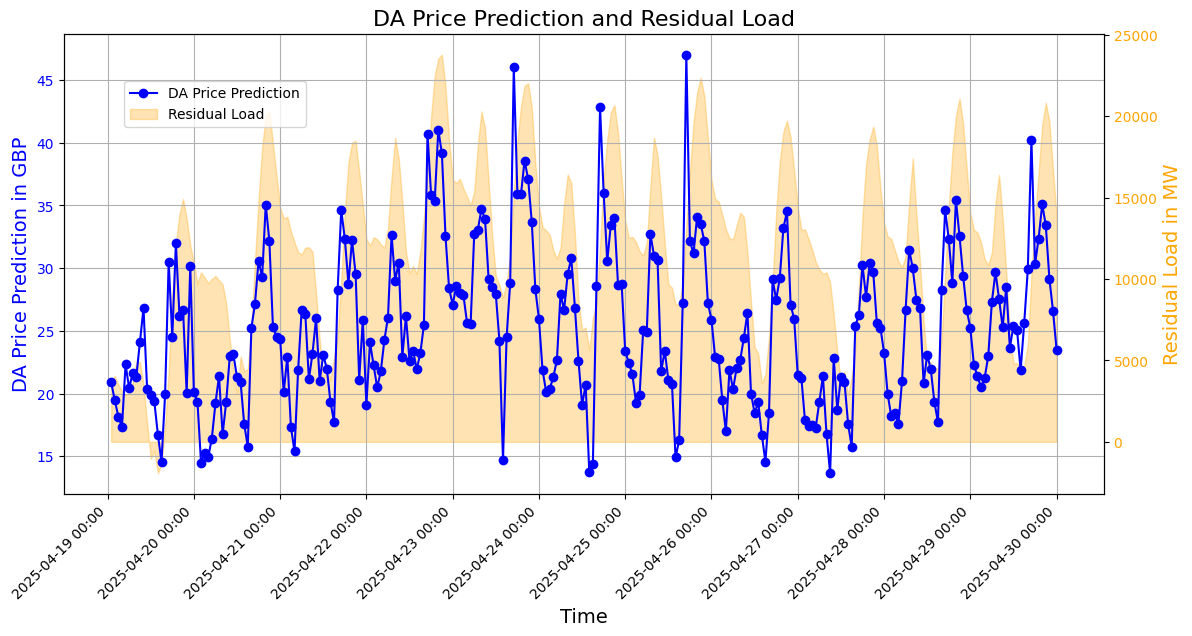

In [78]:
final_forecast_df['date'] = pd.to_datetime(final_forecast_df['date'])

# Erstelle eine vollständige 'datetime'-Spalte
final_forecast_df['datetime'] = final_forecast_df.apply(lambda row: row['date'] + pd.Timedelta(hours=row['hour']), axis=1)



# Plot-Vorbereitung
fig, ax1 = plt.subplots(figsize=(12, 6))

# Preisvorhersagekurve
ax1.plot(final_forecast_df['datetime'], final_forecast_df['da_price_prediction'], color='b', marker='o', label='DA Price Prediction')
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('DA Price Prediction in GBP', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.grid(True)

# Zweite y-Achse für die Restlast
ax2 = ax1.twinx()
ax2.fill_between(final_forecast_df['datetime'], final_forecast_df['residual_load'], color='orange', alpha=0.3, label='Residual Load')
ax2.set_ylabel('Residual Load in MW', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

ax1.set_zorder(ax2.get_zorder() + 1)  # sicherstellen, dass Linienzeichnung oben ist
ax1.patch.set_visible(False)  # Sichtbarkeit oder Synchronisierung verbessern

# Hinzufügen einer Legende
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('DA Price Prediction and Residual Load', fontsize=16)
fig.autofmt_xdate(rotation=45, ha='right')

plt.show()

In [75]:
final_forecast_df = final_forecast_df.drop(columns='datetime')
final_forecast_df.to_csv('output.csv', index=False)